# CNN model

## Notebook set-up

In [15]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import random
from functools import partial

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Local imports
from ariel_data_preprocessing.utils import load_masked_frames
import configuration as config

wavelengths = 283
sample_size = 100

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Data preparation

### 1.1. Load planet list

In [2]:
# Load corrected/extracted data for a sample planet
with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    planet_ids = list(hdf.keys())

print(f'Found {len(planet_ids)} planets in training data.')

Found 1100 planets in training data.


### 1.2. Split planets into training & validation

In [3]:
random.shuffle(planet_ids)

training_planet_ids = planet_ids[:len(planet_ids) // 2]
validation_planet_ids = planet_ids[len(planet_ids) // 2:]

print(f'Training planets: {len(training_planet_ids)}')
print(f'Validation planets: {len(validation_planet_ids)}')

Training planets: 550
Validation planets: 550


## 2. Data generator

### 2.1. Data loader function

In [4]:
def data_loader(planet_ids: list, data_file: str, sample_size: int = 100):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            np.random.shuffle(planet_ids)
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]
                spectrum = hdf[planet_id]['spectrum'][:]

                indices = random.sample(range(signal.shape[0]), sample_size)
                sample = signal[sorted(indices), :]

                yield sample, spectrum


### 2.2. Prefill the arguments to `data_loader()`

In [5]:
training_data_generator = partial(
    data_loader,
    planet_ids=training_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=100
)

validation_data_generator = partial(
    data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=100
)

### 2.3. Create TF datasets

In [6]:
training_dataset = tf.data.Dataset.from_generator(
    training_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, wavelengths), dtype=tf.float64),
        tf.TensorSpec(shape=(wavelengths), dtype=tf.float64)
    )
)

validation_dataset = tf.data.Dataset.from_generator(
    validation_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_size, wavelengths), dtype=tf.float64),
        tf.TensorSpec(shape=(wavelengths), dtype=tf.float64)
    )
)

2025-09-17 23:11:38.980133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6667 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:07:00.0, compute capability: 6.1
2025-09-17 23:11:38.981241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10775 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2025-09-17 23:11:38.982251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10775 MB memory:  -> device: 2, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7


### 2.4. Manually check batch shape

In [ ]:
batch = training_dataset.batch(4)
signals, spectrums = next(iter(batch))

print(f'Signal batch shape: {signals.shape}')
print(f'Spectrum batch shape: {spectrums.shape}')

## 3. CNN

In [7]:
FRAMES = sample_size
WAVELENGTHS = wavelengths
LEARNING_RATE = 0.001
L1_PENALTY = None
L2_PENALTY = None
FILTER_NUMS = [32, 64, 128]
FILTER_SIZE = (3, 3)
BATCH_SIZE = 32
EPOCHS = 20

### 3.1. Model definition

In [8]:
def compile_model(
        frames: int=FRAMES,
        wavelengths: int=WAVELENGTHS,
        learning_rate: float=LEARNING_RATE,
        l1: float=L1_PENALTY,
        l2: float=L2_PENALTY,
        filter_nums=FILTER_NUMS,
        filter_size=FILTER_SIZE
) -> tf.keras.Model:

    '''Builds the convolutional neural network regression model'''

    # Set-up the L1L2 for the dense layers
    regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    # Define the model layers in order
    model = tf.keras.Sequential([
        tf.keras.layers.Input((frames,wavelengths,1)),
        tf.keras.layers.Conv2D(
            filter_nums[0],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[1],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(
            filter_nums[2],
            filter_size,
            padding='same',
            activation='relu',
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            128,
            kernel_regularizer=regularizer,
            activation='relu',
        ),
        tf.keras.layers.Dense(wavelengths, activation='relu')
    ])

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra
    # metrics to evaluate
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(name='MSE'),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )

    return model

In [9]:
model = compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 283, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 141, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 141, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 70, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 70, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 35, 128)      0

In [17]:
training_results = model.fit(
  training_dataset.batch(32),
  validation_data=validation_dataset.batch(32),
  epochs=50,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=1
)

Epoch 1/50


50/50 [==============================] - 17s 334ms/step - loss: 1.1030e-04 - RMSE: 0.0105 - val_loss: 1.1096e-04 - val_RMSE: 0.0105
Epoch 2/50
50/50 [==============================] - 17s 337ms/step - loss: 1.1437e-04 - RMSE: 0.0107 - val_loss: 1.1522e-04 - val_RMSE: 0.0107
Epoch 3/50
50/50 [==============================] - 17s 341ms/step - loss: 1.0709e-04 - RMSE: 0.0103 - val_loss: 1.1418e-04 - val_RMSE: 0.0107
Epoch 4/50
50/50 [==============================] - 17s 353ms/step - loss: 1.1426e-04 - RMSE: 0.0107 - val_loss: 1.1311e-04 - val_RMSE: 0.0106
Epoch 5/50
50/50 [==============================] - 19s 383ms/step - loss: 1.1337e-04 - RMSE: 0.0106 - val_loss: 1.1426e-04 - val_RMSE: 0.0107
Epoch 6/50
50/50 [==============================] - 19s 393ms/step - loss: 1.1418e-04 - RMSE: 0.0107 - val_loss: 1.2653e-04 - val_RMSE: 0.0112
Epoch 7/50
50/50 [==============================] - 18s 368ms/step - loss: 1.1345e-04 - RMSE: 0.0107 - val_loss: 1.1440e-04 - val_RMSE: 0.0107
Epoch 8/50

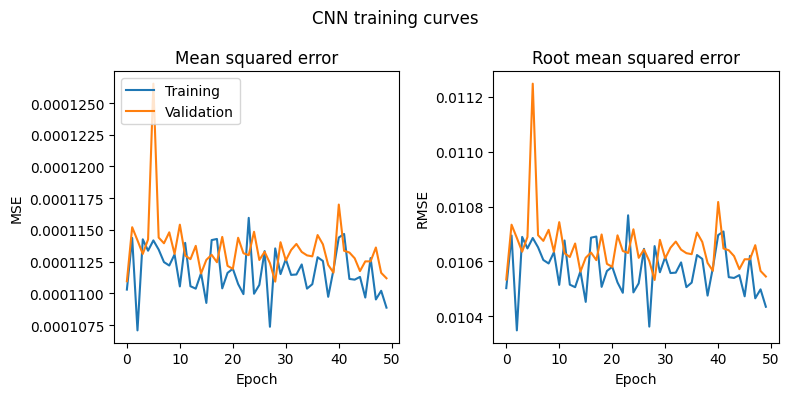

: 

In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation MSE
axs[0].set_title('Mean squared error')
axs[0].plot(np.array(training_results.history['loss']), label='Training')
axs[0].plot(np.array(training_results.history['val_loss']), label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Root mean squared error')
axs[1].plot(training_results.history['RMSE'])
axs[1].plot(training_results.history['val_RMSE'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('RMSE')

# Show the plot
fig.tight_layout()